In [188]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from advertorch.attacks import LinfPGDAttack

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [189]:
torch.manual_seed(1)

n_epochs = 15
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 150

### Define data loaders and data preprocessing steps

In [190]:
data_preprocess = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))])
# the mean of mnist pixel data is .1307 and the stddev is .3081
# the first,second argument to normalize is a sequence of means,standard devs for each input channel
# Normalize subtracts the mean from each value in each channel and divides by the stddev for the channel


train_loader = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST('./data', train=True, download=True,
                         transform=data_preprocess), 
                    batch_size=batch_size_train, 
                    shuffle=True)

test_loader = torch.utils.data.DataLoader(
                    torchvision.datasets.MNIST('./data', train=False, download=True,
                         transform=data_preprocess), 
                    batch_size=batch_size_test, 
                    shuffle=True)

### Define the model

In [191]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc1_drop = nn.Dropout(p=.50)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_drop = nn.Dropout(p=.50)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = self.fc1_drop(F.relu(self.fc1(x)))
        x = self.fc2_drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

### Define my loss function for weighting adversarial examples


In [192]:
def my_loss(output, labels, l2_reg=True, alpha1=.005, jac_reg=False):
    """Combines 
    """
    loss = F.cross_entropy(output, labels)
    
    # add l2 regularization
    if l2_reg:
        l2 = 0
        for p in lenet.parameters():
            l2 += p.pow(2).sum()
        loss = loss + alpha1*l2
    
    # add input-output jacobian regularization
    if jac_reg:
        
    return loss

### Define train and test functions 

In [193]:
def train(epoch):
    lenet.train()

    for batch_idx, (samples, labels) in enumerate(train_loader):
        # send inputs and labels to GPU
        samples, labels = samples.to(0), labels.to(0)
        
        optimizer.zero_grad()
        
        output = lenet(samples)
        
        loss = my_loss(output, labels)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} \tLoss: {loss.item():.6f}')
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))    

In [194]:
def test():
    lenet.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for samples, labels in test_loader:
            samples, labels = samples.to(0), labels.to(0)
            output = lenet(samples)
            # negative log-likelihood loss
            test_loss += my_loss(output, labels).item()
            # output is a tensor, .data retrieves its data, max must return the index of the highest valued element
            preds = output.data.max(1, keepdim=True)[1]
            correct += preds.eq(labels.data.view_as(preds)).sum()
                
    test_loss /= len(test_loader.dataset)
    
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'Test set: \n\tAvg. loss: {test_loss:.4f}\n\tAccuracy: ({accuracy:.2f}%)')
    
    return accuracy, test_loss

### Instantiate model and train it

In [195]:
lenet = LeNet()
lenet.cuda()
optimizer = optim.Adam(lenet.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []
test_accuracies = []
test_losses = []
    
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test_accuracy, test_loss = test()
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

Train Epoch: 1 	Loss: 2.720906
Train Epoch: 1 	Loss: 2.631368
Train Epoch: 1 	Loss: 1.864330
Train Epoch: 1 	Loss: 1.223344
Train Epoch: 1 	Loss: 1.173897
Train Epoch: 1 	Loss: 1.013823
Train Epoch: 1 	Loss: 0.902171
Test set: 
	Avg. loss: 0.0006
	Accuracy: (93.00%)
Train Epoch: 2 	Loss: 0.840336
Train Epoch: 2 	Loss: 0.788598
Train Epoch: 2 	Loss: 0.655963
Train Epoch: 2 	Loss: 0.596241
Train Epoch: 2 	Loss: 0.527363
Train Epoch: 2 	Loss: 0.648543
Train Epoch: 2 	Loss: 0.767238
Test set: 
	Avg. loss: 0.0004
	Accuracy: (96.00%)
Train Epoch: 3 	Loss: 0.724421
Train Epoch: 3 	Loss: 0.693843
Train Epoch: 3 	Loss: 0.437318
Train Epoch: 3 	Loss: 0.550411
Train Epoch: 3 	Loss: 0.556738
Train Epoch: 3 	Loss: 0.564655
Train Epoch: 3 	Loss: 0.586100
Test set: 
	Avg. loss: 0.0004
	Accuracy: (97.00%)
Train Epoch: 4 	Loss: 0.494780
Train Epoch: 4 	Loss: 0.425747
Train Epoch: 4 	Loss: 0.360958
Train Epoch: 4 	Loss: 0.414746
Train Epoch: 4 	Loss: 0.373881
Train Epoch: 4 	Loss: 0.528277
Train Epoch: 

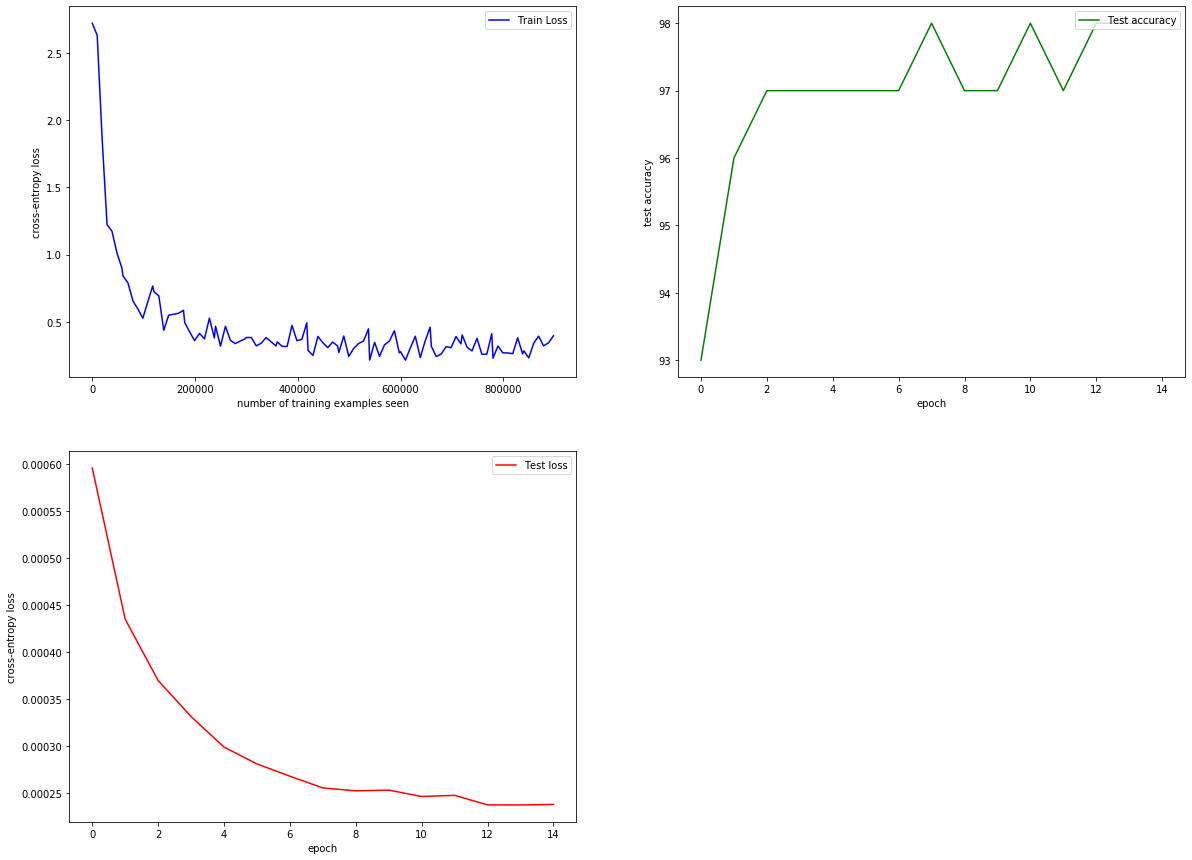

In [196]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(train_counter, train_losses, color='blue')
ax1.legend(['Train Loss'], loc='upper right')
ax1.set_xlabel('number of training examples seen')
ax1.set_ylabel('cross-entropy loss')

ax2 = fig.add_subplot(2,2,2)
ax2.plot(list(range(n_epochs)), test_accuracies, 'green')
ax2.legend(['Test accuracy'], loc='upper right')
ax2.set_xlabel('epoch')
ax2.set_ylabel('test accuracy')

ax3 = fig.add_subplot(2,2,3)
ax3.plot(list(range(n_epochs)), test_losses, 'red')
ax3.legend(['Test loss'], loc='upper right')
ax3.set_xlabel('epoch')
ax3.set_ylabel('cross-entropy loss')

plt.show()